In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

df = pd.read_csv("E:/infovis/yinchuan_tgap2.csv",
    # usecols=['lng','lat','position_time','height','icao',
    #          'icao_segment','speed','heading'],
)


df = df.dropna(subset=['position_time'])

df = df.sort_values(by='position_time')
df = df.drop_duplicates(subset='position_time')

fmt = "%Y/%m/%d %H:%M:%S"   
df['position_time_dt'] = pd.to_datetime(df['position_time'], format=fmt, errors='coerce')

#  将 datetime 转成毫秒时间戳（int64，ms）
df['position_time_dt'] = df['position_time_dt'].astype('int64') // 10**6   # int 毫秒

#  计算 dt（秒）：
df = df.sort_values(['icao_segment','position_time_dt']).reset_index(drop=True)
df['dt'] = df.groupby('icao_segment')['position_time_dt'].diff() / 1000.0   # 秒


In [41]:
df.head()


,Unnamed: 0,icao,altitude,ver_speed_type,lng,lat,height,heading,ver_speed,speed,position_time,callsign,icao_segment,position_time_dt,dt
0,182619,10496125,5105.40,0,105.119218,38.767776,5257.80,270.30804,6.82752,95.688050,2024-10-11 02:37:18.707,HL2121,10496125_1,-9223372036855,NaN
1,182576,10496125,5135.88,0,105.113586,38.767773,5250.18,270.30804,6.82752,95.688050,2024-10-11 02:37:23.928,HL2121,10496125_1,-9223372036855,0.0
2,182482,10496125,5204.46,0,105.102539,38.767819,5318.76,270.30640,6.82752,96.202484,2024-10-11 02:37:33.969,HL2121,10496125_1,-9223372036855,0.0
3,182425,10496125,5227.32,0,105.098499,38.767868,5318.76,270.30640,6.82752,96.202484,2024-10-11 02:37:37.749,HL2121,10496125_1,-9223372036855,0.0
4,182348,10496125,5295.90,0,105.087280,38.767912,5425.44,270.30475,6.50240,96.716930,2024-10-11 02:37:47.710,HL2121,10496125_1,-9223372036855,0.0


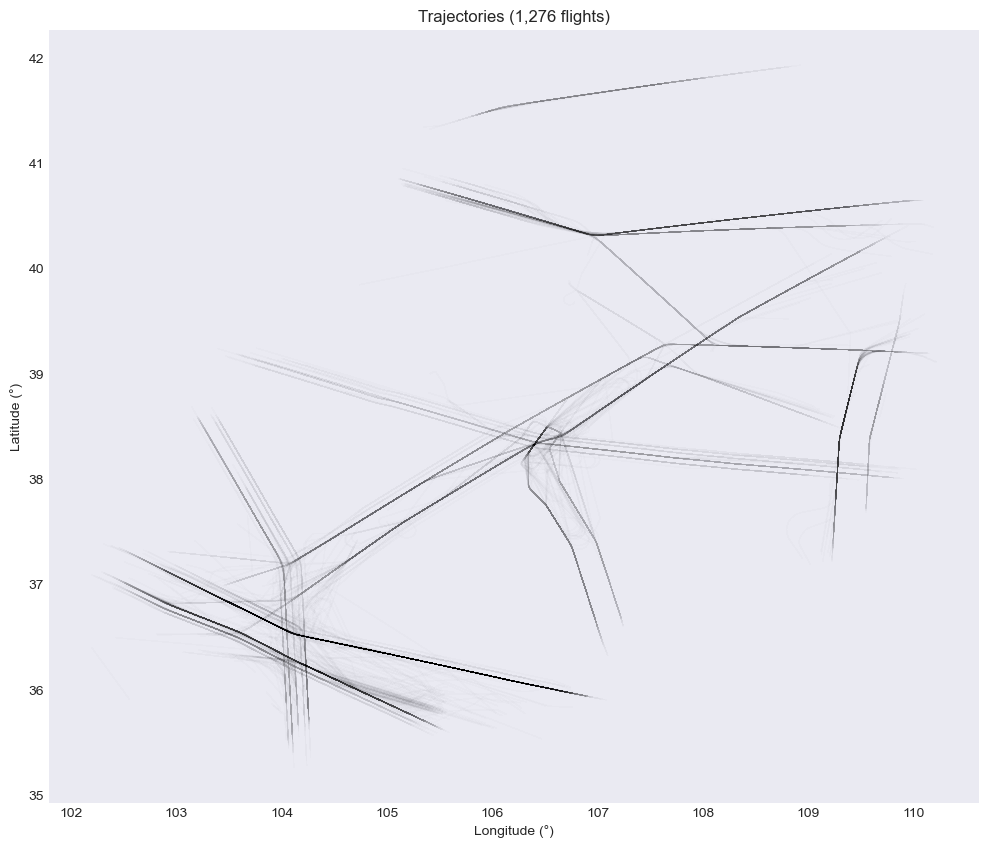

In [69]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# group once (no repeated boolean filters)
groups = df.groupby('icao_segment', sort=False)

# build list of polylines as Nx2 numpy arrays
lines = [np.column_stack((g['lng'].to_numpy(), g['lat'].to_numpy()))
         for _, g in groups if len(g) > 1]

fig, ax = plt.subplots(figsize=(12, 12))
lc = LineCollection(
    lines,
    linewidths=0.4,
    alpha=0.01,       # reduce if still slow; try removing alpha for speed
    antialiased=False,
       colors='black',  # single color is faster than colormap
)
ax.add_collection(lc)
ax.autoscale()        # fits the data bounds
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'Trajectories ({len(lines):,} flights)')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.grid(False)        # grid costs; turn off for speed
plt.show()


In [43]:

track_id = df.groupby("icao_segment").size().idxmax()
track = df[df["icao_segment"] == track_id].reset_index(drop=True)


# 经纬度 → 平面坐标
lat0 = np.radians(track["lat"].iloc[0])
lng0 = track["lng"].iloc[0]
m_per_deg_lat = 111000
m_per_deg_lng = 111000 * np.cos(lat0)

track["x"] = (track["lng"] - track["lng"].iloc[0]) * m_per_deg_lng
track["y"] = (track["lat"] - track["lat"].iloc[0]) * m_per_deg_lat

# 时间间隔 dt
#track["dt"] = track["position_time"].diff() / 1000
#track["dt"].iloc[0] = track["dt"].iloc[1]
track.loc[track.index[0], "dt"] = track.loc[track.index[1], "dt"]

# 速度分解
theta = np.deg2rad(track["heading"])
track["vx"] = track["speed"] * np.cos(theta)
track["vy"] = track["speed"] * np.sin(theta)




In [44]:
from tqdm import tqdm  # 进度条

# 确保数据已加载
print(f"数据框形状: {df.shape}")
print(f"轨迹数量 (icao_segment): {df['icao_segment'].nunique()}")


数据框形状: (103281, 15)
轨迹数量 (icao_segment): 1291


In [45]:
# 存储所有轨迹的结果
all_tracks_results = []
all_smoothed_results = []
all_mse_values = []

# 用于汇总统计
track_summary = []

# 设置最小轨迹长度阈值
MIN_TRACK_LENGTH = 5

# 处理每条轨迹
for track_id, track_group in tqdm(df.groupby("icao_segment"), desc="处理轨迹"):
    track = track_group.reset_index(drop=True)
    
    # 跳过太短的轨迹
    if len(track) < MIN_TRACK_LENGTH:
        continue
    
    try:
        # ==================================================
        # 卡尔曼滤波处理（与之前代码相同）
        # ==================================================
        # 保存原始经latitude用于后续转换
        lat0 = track["lat"].iloc[0]
        lng0 = track["lng"].iloc[0]
        lat0_rad = np.radians(lat0)
        
        # 经latitude → 平面坐标转换参数
        m_per_deg_lat = 111000
        m_per_deg_lng = 111000 * np.cos(lat0_rad)
        
        # 平面坐标转换
        track["x"] = (track["lng"] - lng0) * m_per_deg_lng
        track["y"] = (track["lat"] - lat0) * m_per_deg_lat
        
        # 时间间隔 dt
        if "dt" in track.columns:
            track["dt"] = track["dt"].bfill()
        else:
            track["dt"] = track["position_time"].diff() / 1000
            track["dt"].iloc[0] = track["dt"].iloc[1]
        
        # 速度分解
        theta = np.deg2rad(track["heading"])
        track["vx"] = track["speed"] * np.cos(theta)
        track["vy"] = track["speed"] * np.sin(theta)
        
        # 卡尔曼滤波器
        kf = KalmanFilter(dim_x=2, dim_z=2)
        kf.F = np.array([[1, 0], [0, 1]])
        kf.H = np.eye(2)
        kf.P *= 10
        kf.R = np.eye(2) * 25
        kf.Q = np.eye(2) * 1
        kf.x = np.array([[track["x"].iloc[0]], [track["y"].iloc[0]]])
        
        # 运行卡尔曼滤波
        xs, ys = [], []
        for i in range(len(track)):
            dt = track["dt"].iloc[i]
            kf.B = np.array([[dt, 0], [0, dt]])
            u = np.array([[track["vx"].iloc[i]], [track["vy"].iloc[i]]])
            kf.predict(u=u)
            z = np.array([track["x"].iloc[i], track["y"].iloc[i]])
            kf.update(z)
            xs.append(kf.x[0, 0])
            ys.append(kf.x[1, 0])
        
        # 将平滑后的坐标转换回经latitude
        lng_smoothed = lng0 + np.array(xs) / m_per_deg_lng
        lat_smoothed = lat0 + np.array(ys) / m_per_deg_lat
        
        # 计算RMSE
        n_points = min(len(xs), len(track["x"]))
        if n_points > 0:
            xs_smoothed = xs[:n_points]
            ys_smoothed = ys[:n_points]
            x_true = track["x"].values[:n_points]
            y_true = track["y"].values[:n_points]
            
            point_errors = (xs_smoothed - x_true)**2 + (ys_smoothed - y_true)**2
            mse = np.mean(point_errors)
            
            # 保存结果
            all_mse_values.append(mse)
            
            # 保存轨迹数据（用于可视化）
            track_data = {
                'track_id': track_id,
                'lng_original': track["lng"].values[:n_points],
                'lat_original': track["lat"].values[:n_points],
                'lng_smoothed': lng_smoothed[:n_points],
                'lat_smoothed': lat_smoothed[:n_points],
                'mse': mse,
                'length': n_points
            }
            
            # 添加到汇总
            track_summary.append({
                'track_id': track_id,
                'length': n_points,
                'mse': mse,
                'start_lat': track["lat"].iloc[0],
                'start_lng': track["lng"].iloc[0],
                'end_lat': track["lat"].iloc[-1],
                'end_lng': track["lng"].iloc[-1]
            })
            
            all_tracks_results.append(track_data)
        
    except Exception as e:
        print(f"处理轨迹 {track_id} 时出错: {str(e)}")
        continue

print(f"\n成功处理 {len(all_tracks_results)} 条轨迹")



处理轨迹: 100%|██████████| 1291/1291 [00:06<00:00, 201.37it/s]


成功处理 1230 条轨迹


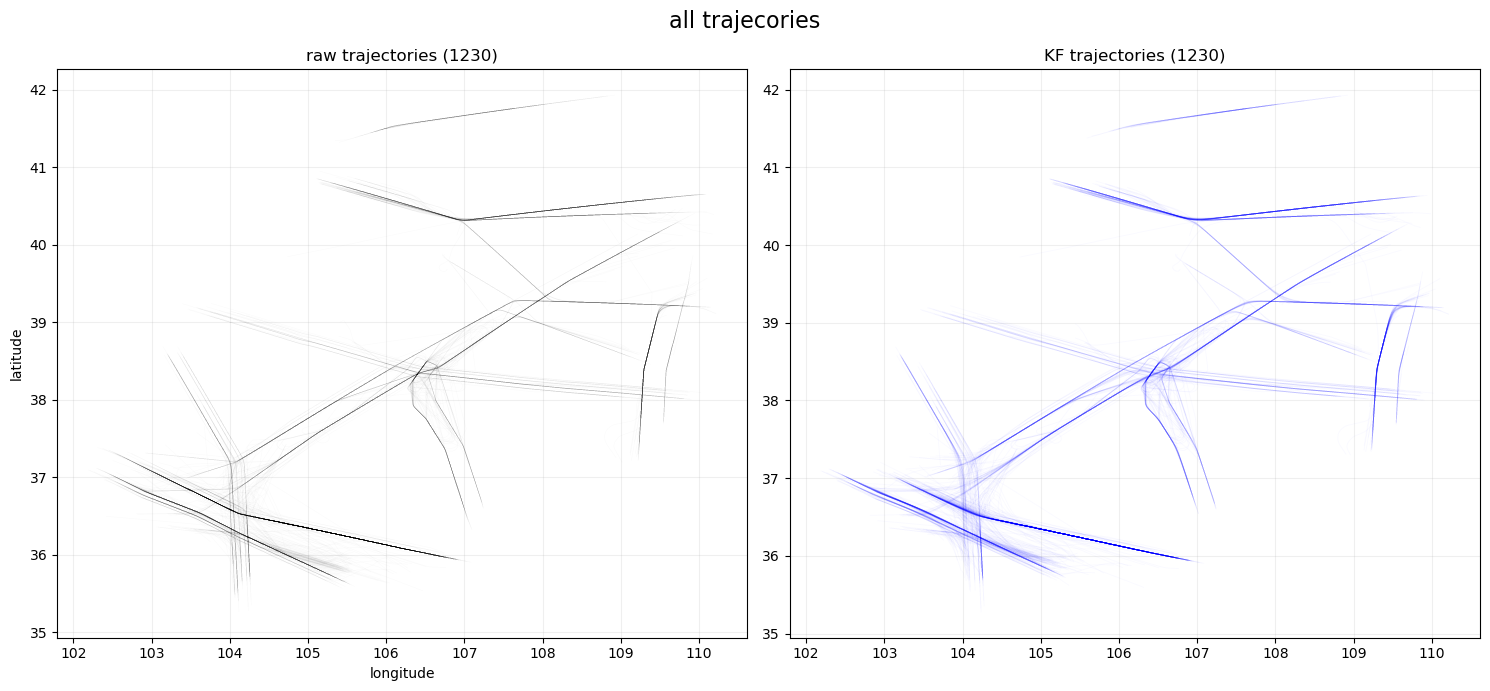

In [46]:
# ==================================================
# 可视化1：所有轨迹的原始和平滑对比（使用透明度）
# ==================================================
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 7))

# 设置透明度参数
# 根据轨迹数量自动调整透明度
alpha_raw = max(0.01, 0.5 / np.sqrt(len(all_tracks_results)))
alpha_smooth = max(0.02, 0.7 / np.sqrt(len(all_tracks_results)))

# 绘制原始轨迹
ax1 = axes1[0]
for track_data in all_tracks_results:
    ax1.plot(track_data['lng_original'], track_data['lat_original'], 
             'k-', alpha=alpha_raw, linewidth=0.5)
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax1.set_title(f'raw trajectories ({len(all_tracks_results)})')
ax1.grid(True, alpha=0.2)

# 绘制平滑轨迹
ax2 = axes1[1]
for track_data in all_tracks_results:
    ax2.plot(track_data['lng_smoothed'], track_data['lat_smoothed'], 
             'b-', alpha=alpha_smooth, linewidth=0.7)
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
ax2.set_title(f'KF trajectories ({len(all_tracks_results)})')
ax2.grid(True, alpha=0.2)

plt.suptitle('all trajecories', fontsize=16)
plt.tight_layout()
plt.show()




Selected 100 baseline trajectories
  Length range: [105, 304]
  MSE range: [9643442.3143, 67630152.8960]

Top 100 trajectories by MSE (best smoothing performance):
  MSE range: [9643442.3143, 67630152.8960]
  Average MSE: 41765823.8578

Extracted 100 baseline trajectories

Visualizing top 10 baseline trajectories...


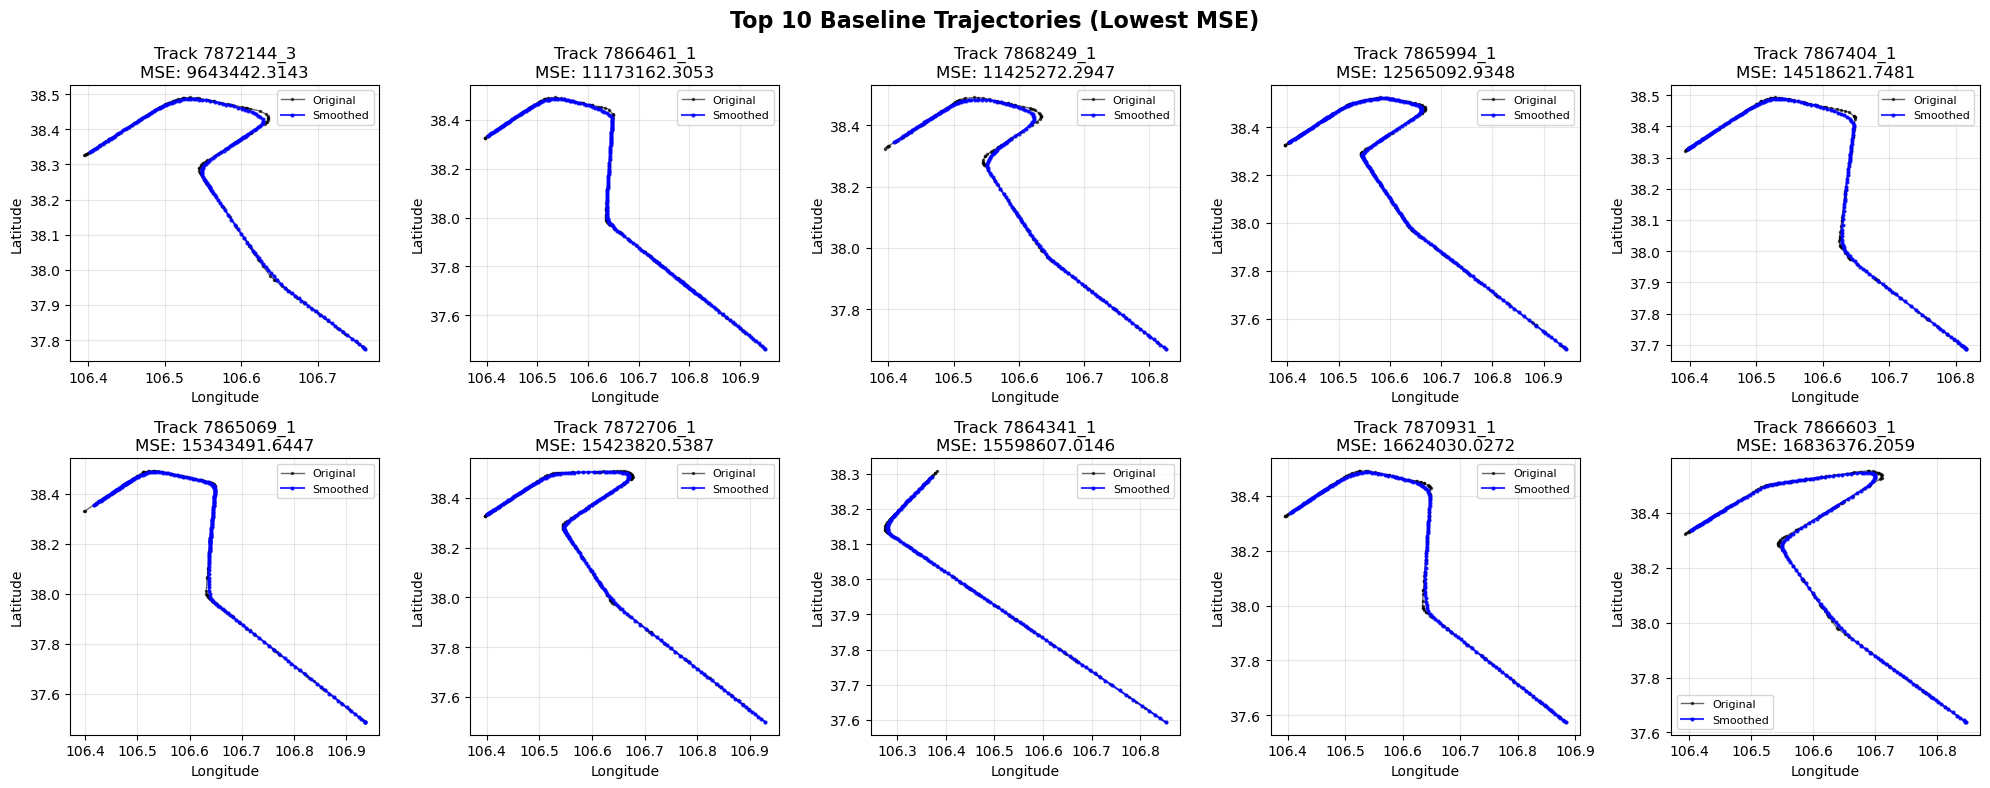

In [47]:
# baseline 生成
#
mse_df = pd.DataFrame({
    'track_id': [track['track_id'] for track in track_summary],
    'mse': [track['mse'] for track in track_summary],
    'length': [track['length'] for track in track_summary]
})
MIN_LENGTH = 100
N_BASELINE = 100

mse_df_filtered = mse_df[mse_df['length'] > MIN_LENGTH].reset_index(drop=True)

if len(mse_df_filtered) < N_BASELINE:
    print(f"⚠️ Warning: only {len(mse_df_filtered)} tracks with length > {MIN_LENGTH}")
    top_100_mse_tracks = mse_df_filtered.sort_values('mse').copy()
else:
    top_100_mse_tracks = (
        mse_df_filtered
        .sort_values(by='mse', ascending=True)
        .head(N_BASELINE)
        .reset_index(drop=True)
    )

print(f"\nSelected {len(top_100_mse_tracks)} baseline trajectories")
print(f"  Length range: [{top_100_mse_tracks['length'].min()}, {top_100_mse_tracks['length'].max()}]")
print(f"  MSE range: [{top_100_mse_tracks['mse'].min():.4f}, {top_100_mse_tracks['mse'].max():.4f}]")

# 升序
mse_df_sorted = mse_df_filtered.sort_values(by='mse', ascending=True).reset_index(drop=True)
# 选取前100条轨迹
top_100_mse_tracks = mse_df_sorted.head(100)
print(f"\nTop 100 trajectories by MSE (best smoothing performance):")
print(f"  MSE range: [{top_100_mse_tracks['mse'].min():.4f}, {top_100_mse_tracks['mse'].max():.4f}]")
print(f"  Average MSE: {top_100_mse_tracks['mse'].mean():.4f}")

# 提取baseline轨迹数据
baseline_tracks = []
for track_id in top_100_mse_tracks['track_id']:
    # 在all_tracks_results中找到对应的轨迹
    for track_data in all_tracks_results:
        if track_data['track_id'] == track_id:
            baseline_tracks.append(track_data)
            break

print(f"\nExtracted {len(baseline_tracks)} baseline trajectories")

# ==================================================
# 可视化MSE分布和baseline选择
# ==================================================

print("\nVisualizing top 10 baseline trajectories...")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(min(10, len(baseline_tracks))):
    track_data = baseline_tracks[i]
    ax = axes[i]
    
    # 绘制原始轨迹
    ax.plot(track_data['lng_original'], track_data['lat_original'], 'k.-', 
           alpha=0.6, markersize=3, linewidth=1, label='Original')
    
    # 绘制平滑轨迹
    ax.plot(track_data['lng_smoothed'], track_data['lat_smoothed'], 'b.-', 
           alpha=0.8, markersize=4, linewidth=1.5, label='Smoothed')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Track {track_data["track_id"]}\nMSE: {track_data["mse"]:.4f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# 隐藏多余的子图
for i in range(min(10, len(baseline_tracks)), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Top 10 Baseline Trajectories (Lowest MSE)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [48]:
baseline_rows = []

for track_data in baseline_tracks:
    track_id = track_data['track_id']
    mse = track_data['mse']
    
    lngs = track_data['lng_original']
    lats = track_data['lat_original']
    
    for i, (lng, lat) in enumerate(zip(lngs, lats)):
        baseline_rows.append({
            'track_id': track_id,
            'point_idx': i,
            'lng_original': lng,
            'lat_original': lat,
            'lng_smoothed': track_data['lng_smoothed'][i],
            'lat_smoothed': track_data['lat_smoothed'][i],
            'mse': mse
        })

baseline_df = pd.DataFrame(baseline_rows)

# 保存
save_path = 'baseline_kf_top100.csv'
baseline_df.to_csv(save_path, index=False)

print(f"Baseline original trajectories saved to: {save_path}")
print(baseline_df.head())


Baseline original trajectories saved to: baseline_kf_top100.csv
    track_id  point_idx  lng_original  lat_original  lng_smoothed  \
0  7872144_3          0    106.761923     37.775620    106.761923   
1  7872144_3          1    106.757364     37.783218    106.760752   
2  7872144_3          2    106.751284     37.793295    106.758585   
3  7872144_3          3    106.736298     37.817967    106.753862   
4  7872144_3          4    106.732118     37.824810    106.749487   

   lat_smoothed           mse  
0     37.775620  9.643442e+06  
1     37.777571  9.643442e+06  
2     37.781170  9.643442e+06  
3     37.788967  9.643442e+06  
4     37.796179  9.643442e+06  


In [49]:
#  加载baseline轨迹数据
baseline_df = pd.read_csv(save_path)
print(f"Loaded {len(baseline_df)} baseline trajectories")

Loaded 19310 baseline trajectories


In [50]:
# 添加噪声
# Adds noise/drift/spikes

import numpy as np
from scipy.spatial.distance import cdist

def normalize_trajectory(xy_data, global_min=None, global_max=None):
    """
    将轨迹坐标归一化到[0,1]范围
    
    参数:
    xy_data: numpy数组，形状为(n, 2)，表示2D轨迹点
    global_min: 全局最小值，如果为None则从当前数据计算
    global_max: 全局最大值，如果为None则从当前数据计算
    
    返回:
    normalized_data: 归一化后的数据
    min_vals: 最小值
    max_vals: 最大值
    """
    if global_min is None or global_max is None:
        min_vals = np.min(xy_data, axis=0)
        max_vals = np.max(xy_data, axis=0)
    else:
        min_vals = global_min
        max_vals = global_max
    
    # 避免除零
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1.0
    
    # 归一化到[0,1]
    normalized_data = (xy_data - min_vals) / range_vals
    
    return normalized_data, min_vals, max_vals

def denormalize_trajectory(normalized_data, min_vals, max_vals):
    """ 
    将归一化坐标反归一化回原始范围
    
    参数:
    normalized_data: 归一化后的数据
    min_vals: 最小值
    max_vals: 最大值
    
    返回:
    反归一化后的数据
    """
    range_vals = max_vals - min_vals
    denormalized_data = normalized_data * range_vals + min_vals
    
    return denormalized_data

def add_noise_normalized(xy: np.ndarray, T: int,
                         noise_std: float = 0.003,
                         drift_mag: float = 0.00,
                         spike_prob: float = 0.00,
                         spike_scale: float = 4.0,
                         seed: int = 42,
                         clamp: bool = True):
    """
    在归一化空间[0,1]中添加噪声
    
    参数:
    xy: (n, 2T) 归一化后的轨迹，在[0,1]范围内
    noise_std: 高斯噪声的标准差（归一化单位）
    drift_mag: 每个轨迹的恒定漂移幅度（归一化单位）
    spike_prob: 每个样本出现尖峰的概率（0..1）
    spike_scale: 尖峰噪声相对于noise_std的倍数
    """
    rng = np.random.default_rng(seed)
    n = xy.shape[0]
    lon = xy[:, :T].copy()
    lat = xy[:, T:].copy()

    # Gaussian jitter
    ex = rng.normal(0.0, noise_std, size=lon.shape).astype(np.float32)
    ey = rng.normal(0.0, noise_std, size=lat.shape).astype(np.float32)

    # Constant drift (random direction, same across T)
    if drift_mag != 0.0:
        drift_dir = rng.normal(0.0, 1.0, size=(n, 2)).astype(np.float32)
        drift_dir /= (np.linalg.norm(drift_dir, axis=1, keepdims=True) + 1e-9)
        dx = (drift_dir[:, 0:1] * drift_mag).repeat(T, axis=1)
        dy = (drift_dir[:, 1:2] * drift_mag).repeat(T, axis=1)
        ex += dx
        ey += dy

    # Sparse spikes
    if spike_prob > 0.0:
        spikes = rng.random(lon.shape) < spike_prob
        ex += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lon.shape)
        ey += spikes * rng.normal(0.0, spike_scale * max(noise_std, 1e-9), size=lat.shape)

    lon_noisy = lon + ex
    lat_noisy = lat + ey

    if clamp:
        lon_noisy = np.clip(lon_noisy, 0.0, 1.0)
        lat_noisy = np.clip(lat_noisy, 0.0, 1.0)

    noisy = np.concatenate([lon_noisy, lat_noisy], axis=1).astype(np.float32, copy=False)
    return noisy

def add_noise_to_trajectory(trajectory_points, 
                           noise_type='gaussian', 
                           noise_level=0.003,
                           drift_magnitude=0.005,
                           spike_probability=0.01,
                           spike_scale=4.0,
                           seed=42):
    """
    为单个轨迹添加噪声
    
    参数:
    trajectory_points: numpy数组，形状为(n, 2)，表示2D轨迹点
    noise_type: 噪声类型 ('gaussian', 'drift', 'spike', 'mixed')
    noise_level: 噪声水平（高斯噪声的标准差）
    drift_magnitude: 漂移幅度
    spike_probability: 尖峰概率
    spike_scale: 尖峰噪声倍数
    
    返回:
    noisy_trajectory: 添加噪声后的轨迹
    """
    # 归一化轨迹坐标到[0,1]
    normalized_points, min_vals, max_vals = normalize_trajectory(trajectory_points)
    
    T = len(trajectory_points)
    #n = 1  # 单个轨迹
    
    # 准备输入数据：形状为(1, 2T)
    xy_input = np.concatenate([normalized_points[:, 0].reshape(1, -1), 
                              normalized_points[:, 1].reshape(1, -1)], axis=1)
    
    # 根据噪声类型设置参数
    if noise_type == 'gaussian':
        noisy_normalized = add_noise_normalized(xy_input, T, noise_std=noise_level, seed=seed)
    elif noise_type == 'drift':
        noisy_normalized = add_noise_normalized(xy_input, T, noise_std=0.0, 
                                               drift_mag=drift_magnitude, seed=seed)
    elif noise_type == 'spike':
        noisy_normalized = add_noise_normalized(xy_input, T, noise_std=0.0,
                                               spike_prob=spike_probability,
                                               spike_scale=spike_scale, seed=seed)
    elif noise_type == 'mixed':
        noisy_normalized = add_noise_normalized(xy_input, T, 
                                               noise_std=noise_level,
                                               drift_mag=drift_magnitude,
                                               spike_prob=spike_probability,
                                               spike_scale=spike_scale, seed=seed)
    else:
        raise ValueError(f"Unsupported noise type: {noise_type}")
    
    # 从噪声数据中提取x和y
    x_noisy_normalized = noisy_normalized[0, :T]
    y_noisy_normalized = noisy_normalized[0, T:]
    
    # 反归一化
    x_noisy = denormalize_trajectory(x_noisy_normalized.reshape(-1, 1), 
                                     min_vals[0], max_vals[0]).flatten()
    y_noisy = denormalize_trajectory(y_noisy_normalized.reshape(-1, 1), 
                                     min_vals[1], max_vals[1]).flatten()
    
    # 组合成轨迹点
    noisy_trajectory = np.column_stack([x_noisy, y_noisy])
    
    return noisy_trajectory

def add_noise_to_all_baselines_df(
    baseline_df,
    noise_type='gaussian',
    noise_level=0.003,
    drift_magnitude=0.005,
    spike_probability=0.01,
    spike_scale=4.0,
    seed=42
):
    noisy_rows = []

    for i, (track_id, group) in enumerate(baseline_df.groupby('track_id')):
        group = group.sort_values('point_idx')

        trajectory_points = group[['lng_original', 'lat_original']].values

        noisy_points = add_noise_to_trajectory(
            trajectory_points,
            noise_type=noise_type,
            noise_level=noise_level,
            drift_magnitude=drift_magnitude,
            spike_probability=spike_probability,
            spike_scale=spike_scale,
            seed=seed + i
        )

        for k, row in group.iterrows():
            noisy_rows.append({
                'track_id': track_id,
                'point_idx': row['point_idx'],
                'lng_original': row['lng_original'],
                'lat_original': row['lat_original'],
                'lng_smoothed': row['lng_smoothed'],
                'lat_smoothed': row['lat_smoothed'],
                'lng_noisy': noisy_points[row['point_idx'], 0],
                'lat_noisy': noisy_points[row['point_idx'], 1],
                'noise_type': noise_type,
                'noise_level': noise_level,
                'mse': row['mse']
            })

    return pd.DataFrame(noisy_rows)


def create_multiple_noise_scenarios(baseline_tracks, noise_scenarios=None):
    """
    创建多个噪声场景
    
    参数:
    baseline_tracks: baseline轨迹列表
    noise_scenarios: 噪声场景配置列表，每个元素是一个字典
    
    返回:
    包含所有噪声场景的字典
    """
    if noise_scenarios is None:
        # 默认噪声场景
        noise_scenarios = [
            {'name': 'low_gaussian', 'type': 'gaussian', 'level': 0.001, 'seed': 100},
            {'name': 'medium_gaussian', 'type': 'gaussian', 'level': 0.003, 'seed': 200},
            {'name': 'high_gaussian', 'type': 'gaussian', 'level': 0.01, 'seed': 300},
            {'name': 'drift_only', 'type': 'drift', 'magnitude': 0.005, 'seed': 400},
            {'name': 'spike_only', 'type': 'spike', 'probability': 0.02, 'seed': 500},
            {'name': 'mixed_low', 'type': 'mixed', 'level': 0.002, 'magnitude': 0.003, 
             'probability': 0.01, 'seed': 600},
            {'name': 'mixed_high', 'type': 'mixed', 'level': 0.005, 'magnitude': 0.008,
             'probability': 0.03, 'seed': 700}
        ]
    
    all_noisy_scenarios = {}
    
    for scenario in noise_scenarios:
        print(f"Processing noise scenario: {scenario['name']}")
        
        # 提取参数
        noise_type = scenario.get('type', 'gaussian')
        noisy_df = add_noise_to_all_baselines_df(
            baseline_df,
            noise_type=noise_type,
            noise_level=scenario.get('level',0.003),
            drift_magnitude=scenario.get('magnitude',0.005),
            spike_probability=scenario.get('probability',0.01),
            spike_scale=scenario.get('spike_scale',4.0),
            seed=scenario.get('seed',42)
        )
        # if noise_type == 'gaussian':
        #     noisy_tracks = add_noise_to_all_baselines_df(
        #         baseline_tracks, 
        #         noise_type='gaussian',
        #         noise_level=scenario.get('level', 0.003),
        #         seed=scenario.get('seed', 42)
        #     )
        # elif noise_type == 'drift':
        #     noisy_tracks = add_noise_to_all_baselines(
        #         baseline_tracks,
        #         noise_type='drift',
        #         drift_magnitude=scenario.get('magnitude', 0.005),
        #         seed=scenario.get('seed', 42)
        #     )
        # elif noise_type == 'spike':
        #     noisy_tracks = add_noise_to_all_baselines(
        #         baseline_tracks,
        #         noise_type='spike',
        #         spike_probability=scenario.get('probability', 0.01),
        #         seed=scenario.get('seed', 42)
        #     )
        # elif noise_type == 'mixed':
        #     noisy_tracks = add_noise_to_all_baselines(
        #         baseline_tracks,
        #         noise_type='mixed',
        #         noise_level=scenario.get('level', 0.003),
        #         drift_magnitude=scenario.get('magnitude', 0.005),
        #         spike_probability=scenario.get('probability', 0.01),
        #         seed=scenario.get('seed', 42)
        #     )

        # 计算噪声幅度
        noisy_df['noise_magnitude'] = np.sqrt(
            (noisy_df['lng_noisy'] - noisy_df['lng_smoothed'])**2 +
            (noisy_df['lat_noisy'] - noisy_df['lat_smoothed'])**2
        )
        noisy_df['avg_noise_magnitude'] = noisy_df.groupby('track_id')['noise_magnitude'].transform('mean')
        noisy_df['max_noise_magnitude'] = noisy_df.groupby('track_id')['noise_magnitude'].transform('max')
        all_noisy_scenarios[scenario['name']] = noisy_df
    
    return all_noisy_scenarios


# ==================================================
# 可视化添加噪声的效果
# ==================================================
import matplotlib.pyplot as plt

def visualize_noisy_trajectories(original_track_df, noisy_track_df, title="Trajectory with Noise"):
    """
    可视化 DataFrame 中的轨迹
    original_track_df: baseline_df 中单条轨迹
    noisy_track_df: noisy_df 中同一条轨迹
    """
    fig, ax = plt.subplots(figsize=(6,5))
    
    # 绘制原始轨迹
    ax.plot(original_track_df['lng_smoothed'], original_track_df['lat_smoothed'], 
            'k-', label='Original', linewidth=2)
    
    # 绘制噪声轨迹
    ax.plot(noisy_track_df['lng_noisy'], noisy_track_df['lat_noisy'], 
            'r-', label=f"Noisy ({noisy_track_df['noise_type'].iloc[0]})", linewidth=1.5)
    
    # 显示部分连接线
    step = max(1, len(original_track_df)//20)
    for i in range(0, len(original_track_df), step):
        ax.plot([original_track_df['lng_smoothed'].iloc[i], noisy_track_df['lng_noisy'].iloc[i]],
                [original_track_df['lat_smoothed'].iloc[i], noisy_track_df['lat_noisy'].iloc[i]],
                'g-', alpha=0.3, linewidth=0.5)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()


In [51]:
# 设置混合噪声参数
mixed_noise_params = {
    'noise_type': 'mixed',
    'noise_level': 0.003,      # 高斯噪声水平
    'drift_magnitude': 0.005,  # 漂移幅度
    'spike_probability': 0.01, # 尖峰概率
    'spike_scale': 4.0,       # 尖峰噪声倍数
    'seed': 42                # 随机种子
}

noisy_baselines_mixed = add_noise_to_all_baselines_df(
    baseline_df,
    noise_type='mixed',
    noise_level=0.003,
    drift_magnitude=0.005,
    spike_probability=0.01,
    spike_scale=4.0,
    seed=42
)

print(noisy_baselines_mixed.head())
print(noisy_baselines_mixed['track_id'].nunique())

    track_id  point_idx  lng_original  lat_original  lng_smoothed  \
0  7864341_1          0    106.852151     37.593521    106.852151   
1  7864341_1          1    106.809140     37.634674    106.841105   
2  7864341_1          2    106.792193     37.650833    106.829910   
3  7864341_1          3    106.777526     37.664749    106.818810   
4  7864341_1          4    106.738606     37.701599    106.802672   

   lat_smoothed   lng_noisy  lat_noisy noise_type  noise_level           mse  
0     37.593521  106.850560  37.596713      mixed        0.003  1.559861e+07  
1     37.604090  106.805218  37.640236      mixed        0.003  1.559861e+07  
2     37.614788  106.791376  37.650715      mixed        0.003  1.559861e+07  
3     37.625375  106.777038  37.665806      mixed        0.003  1.559861e+07  
4     37.640713  106.733103  37.702042      mixed        0.003  1.559861e+07  
100


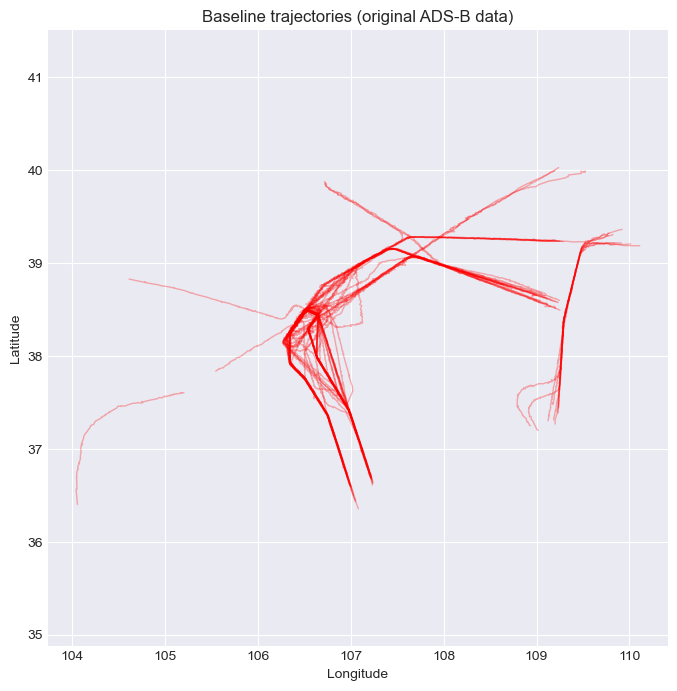

In [68]:
#含噪baseline可视化
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

for track_id, g in noisy_baselines_mixed.groupby('track_id'):
    # plt.plot(
    #     g['lng_original'],
    #     g['lat_original'],
    #     color='black',
    #     alpha=0.3,
    #     linewidth=1
    # )
    plt.plot(
        g['lng_noisy'],
        g['lat_noisy'],
        color='r',
        alpha=0.3,
        linewidth=1
    )
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Baseline trajectories (original ADS-B data)")
plt.axis('equal')
plt.grid(True)
plt.show()



Noise statistics for mixed noise scenario:
  Average noise across all trajectories: 0.05 m
  Maximum noise across all trajectories: 0.19 m
  Overall average noise per point: 0.05 m
  Overall max noise per point: 0.38 m
  Noise std per point: 0.04 m

Visualizing noise effects on sample trajectories...


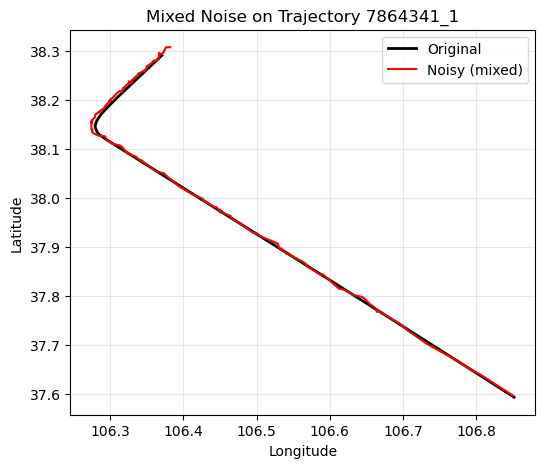

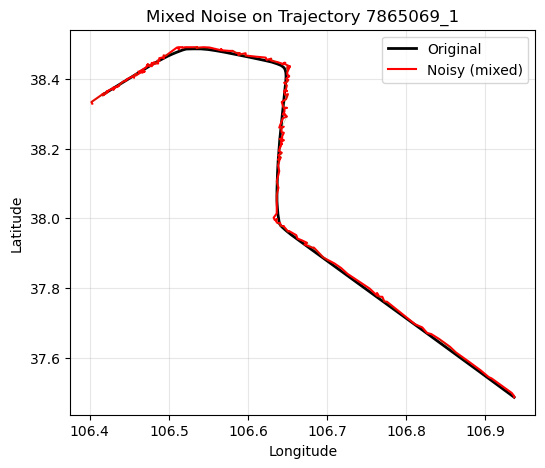

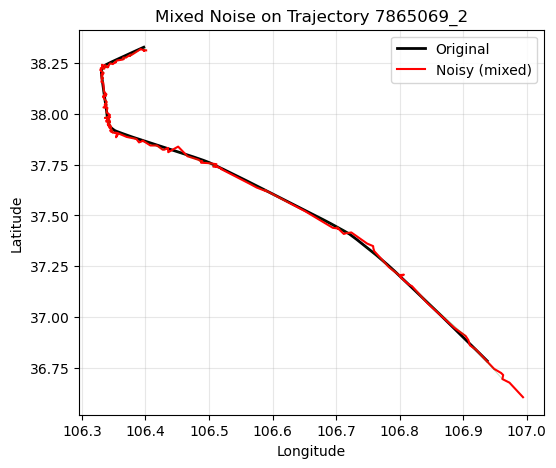

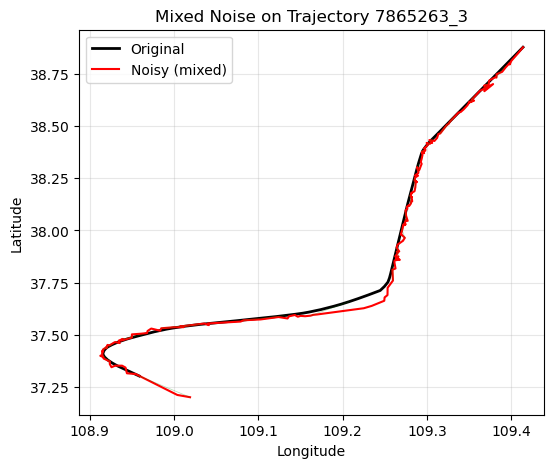

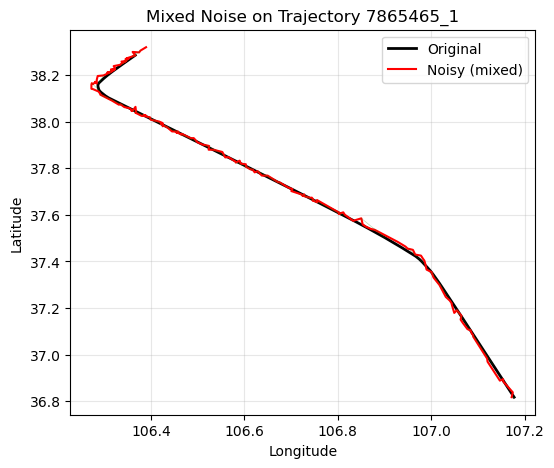

In [53]:
# ==================================================
# 3. 统计噪声信息
# ==================================================
print("\nNoise statistics for mixed noise scenario:")

# 收集所有轨迹的噪声统计
all_avg_noises = []
all_max_noises = []
noise_distributions = []

for track_id, group in noisy_baselines_mixed.groupby('track_id'):
    # 每条轨迹的噪声 magnitude
    noise_magnitudes = np.sqrt(
        (group['lng_noisy'] - group['lng_smoothed'])**2 +
        (group['lat_noisy'] - group['lat_smoothed'])**2
    )
    
    all_avg_noises.append(noise_magnitudes.mean())
    all_max_noises.append(noise_magnitudes.max())
    noise_distributions.extend(noise_magnitudes)

print(f"  Average noise across all trajectories: {np.mean(all_avg_noises):.2f} m")
print(f"  Maximum noise across all trajectories: {np.mean(all_max_noises):.2f} m")
print(f"  Overall average noise per point: {np.mean(noise_distributions):.2f} m")
print(f"  Overall max noise per point: {np.max(noise_distributions):.2f} m")
print(f"  Noise std per point: {np.std(noise_distributions):.2f} m")

# ==================================================
# 4. 可视化几条轨迹的噪声效果
# ==================================================
print("\nVisualizing noise effects on sample trajectories...")

# 选择前5条轨迹进行可视化
n_sample = min(5, noisy_baselines_mixed['track_id'].nunique())
sample_track_ids = noisy_baselines_mixed['track_id'].unique()[:n_sample]

for track_id in sample_track_ids:
    track_clean = baseline_df[baseline_df['track_id'] == track_id].sort_values('point_idx')
    track_noisy = noisy_baselines_mixed[noisy_baselines_mixed['track_id'] == track_id].sort_values('point_idx')

    visualize_noisy_trajectories(
        track_clean,
        track_noisy,
        title=f"Mixed Noise on Trajectory {track_id}"
    )


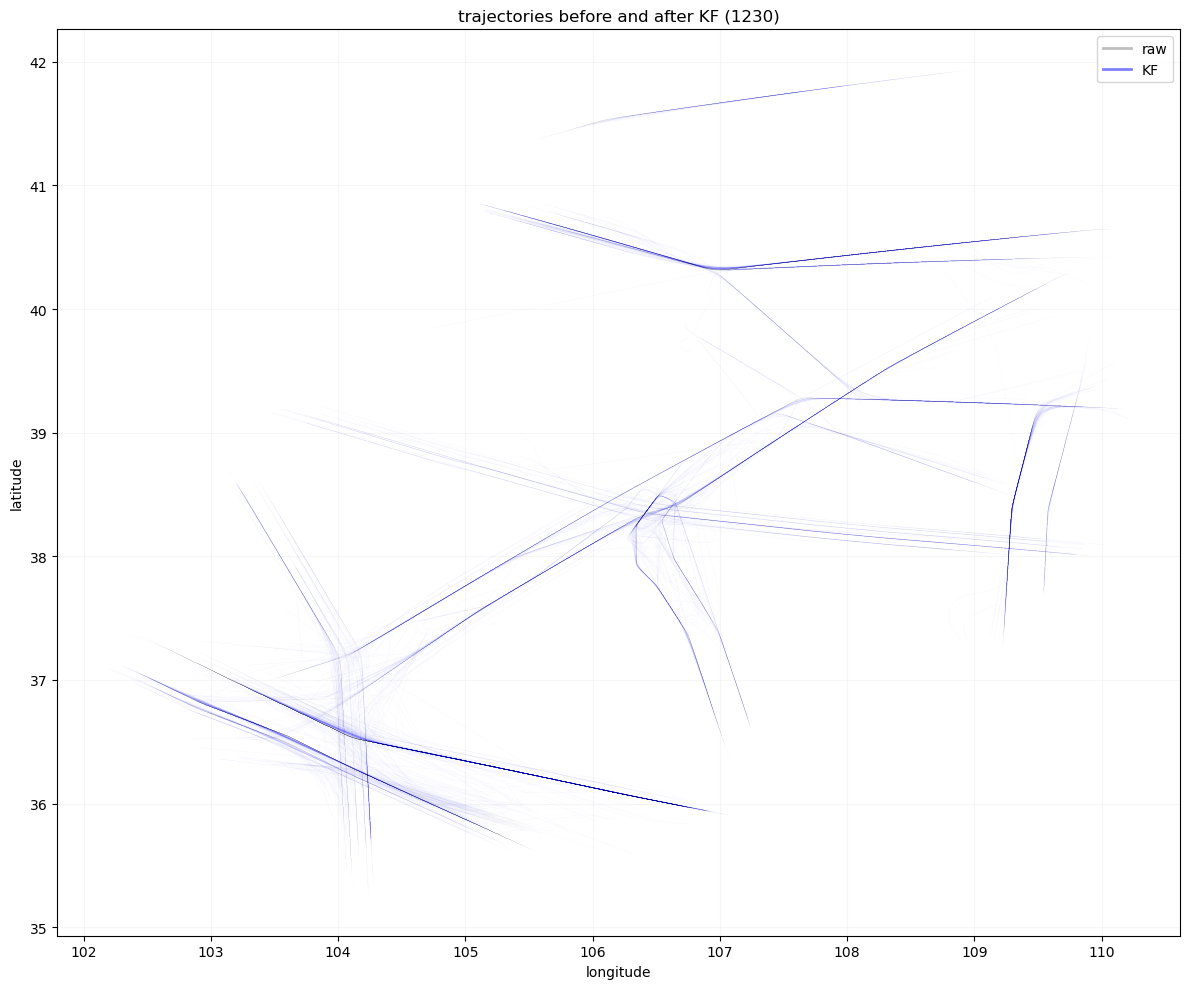

In [54]:
# ==================================================
# 可视化2：叠加显示原始和平滑轨迹
# ==================================================
fig2, ax3 = plt.subplots(figsize=(12, 10))

# 使用更低的透明度来区分重叠轨迹
alpha_overlay_raw = max(0.005, 0.3 / np.sqrt(len(all_tracks_results)))
alpha_overlay_smooth = max(0.01, 0.5 / np.sqrt(len(all_tracks_results)))

# 绘制原始轨迹（灰色）
for track_data in all_tracks_results:
    ax3.plot(track_data['lng_original'], track_data['lat_original'], 
             'gray', alpha=alpha_overlay_raw, linewidth=0.3, label='_nolegend_')

# 绘制平滑轨迹（蓝色）
for track_data in all_tracks_results:
    ax3.plot(track_data['lng_smoothed'], track_data['lat_smoothed'], 
             'blue', alpha=alpha_overlay_smooth, linewidth=0.5, label='_nolegend_')

# 创建图例元素
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='gray', alpha=0.5, lw=2, label='raw'),
    Line2D([0], [0], color='blue', alpha=0.5, lw=2, label='KF')
]

ax3.legend(handles=legend_elements, loc='upper right')
ax3.set_xlabel('longitude')
ax3.set_ylabel('latitude')
ax3.set_title(f'trajectories before and after KF ({len(all_tracks_results)})')
ax3.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()



In [55]:
# 将含噪的baseline数据注入KF中

def run_kf_on_trajectory(df_track, obs_lng_col, obs_lat_col):
    """
    对单条轨迹运行 KF
    obs_lng_col / obs_lat_col 决定观测来自哪里
    """

    # reset index
    df_track = df_track.sort_values("point_idx").reset_index(drop=True)

    # 基准点
    lat0 = df_track[obs_lat_col].iloc[0]
    lng0 = df_track[obs_lng_col].iloc[0]
    lat0_rad = np.radians(lat0)

    m_per_deg_lat = 111000
    m_per_deg_lng = 111000 * np.cos(lat0_rad)

    # 观测坐标（⚠ noisy or original）
    x_obs = (df_track[obs_lng_col] - lng0) * m_per_deg_lng
    y_obs = (df_track[obs_lat_col] - lat0) * m_per_deg_lat

    # dt（如果没有就用 1）
    if "dt" in df_track.columns:
        dt_series = df_track["dt"].bfill().to_numpy()  # 转为 ndarray，统一索引访问
    else:
        dt_series = np.ones(len(df_track))
    
    # KF
    kf = KalmanFilter(dim_x=2, dim_z=2)
    kf.F = np.eye(2)
    kf.H = np.eye(2)
    kf.P *= 10
    kf.R = np.eye(2) * 25
    kf.Q = np.eye(2) * 1
    kf.x = np.array([[x_obs.iloc[0]], [y_obs.iloc[0]]])

    xs, ys = [], []

    for i in range(len(df_track)):
        dt = dt_series[i]  # ✅ 使用索引访问
        kf.B = np.array([[dt, 0], [0, dt]])
        u = np.zeros((2, 1))  # ⚠ baseline/noisy 都保持一致
        kf.predict(u=u)

        z = np.array([x_obs.iloc[i], y_obs.iloc[i]])
        kf.update(z)

        xs.append(kf.x[0, 0])
        ys.append(kf.x[1, 0])

    # 转回经纬度
    lng_kf = lng0 + np.array(xs) / m_per_deg_lng
    lat_kf = lat0 + np.array(ys) / m_per_deg_lat

    return lng_kf, lat_kf

kf_results_noisy = []

for track_id, group in noisy_baselines_mixed.groupby("track_id"):
    lng_kf, lat_kf = run_kf_on_trajectory(
        group,
        obs_lng_col="lng_noisy",
        obs_lat_col="lat_noisy"
    )

    group = group.copy()
    group["lng_kf_noisy"] = lng_kf
    group["lat_kf_noisy"] = lat_kf

    kf_results_noisy.append(group)

kf_noisy_df = pd.concat(kf_results_noisy, ignore_index=True)


In [56]:
print(kf_noisy_df.head())

    track_id  point_idx  lng_original  lat_original  lng_smoothed  \
0  7864341_1          0    106.852151     37.593521    106.852151   
1  7864341_1          1    106.809140     37.634674    106.841105   
2  7864341_1          2    106.792193     37.650833    106.829910   
3  7864341_1          3    106.777526     37.664749    106.818810   
4  7864341_1          4    106.738606     37.701599    106.802672   

   lat_smoothed   lng_noisy  lat_noisy noise_type  noise_level           mse  \
0     37.593521  106.850560  37.596713      mixed        0.003  1.559861e+07   
1     37.604090  106.805218  37.640236      mixed        0.003  1.559861e+07   
2     37.614788  106.791376  37.650715      mixed        0.003  1.559861e+07   
3     37.625375  106.777038  37.665806      mixed        0.003  1.559861e+07   
4     37.640713  106.733103  37.702042      mixed        0.003  1.559861e+07   

   lng_kf_noisy  lat_kf_noisy  
0    106.850560     37.596713  
1    106.838916     37.607890  
2    106

In [57]:
def trajectory_rmse(df, pred_lng, pred_lat, gt_lng, gt_lat):
    diff_lng = df[pred_lng] - df[gt_lng]
    diff_lat = df[pred_lat] - df[gt_lat]
    mse = np.mean(diff_lng**2 + diff_lat**2)
    rmse = np.sqrt(mse)
    return rmse

rmse_clean_kf = trajectory_rmse(
    kf_noisy_df,
    pred_lng="lng_smoothed",
    pred_lat="lat_smoothed",
    gt_lng="lng_original",
    gt_lat="lat_original"
)

rmse_noisy_kf = trajectory_rmse(
    kf_noisy_df,
    pred_lng="lng_kf_noisy",
    pred_lat="lat_kf_noisy",
    gt_lng="lng_original",
    gt_lat="lat_original"
)

print("RMSE (Original → KF):", rmse_clean_kf)
print("RMSE (Noisy → KF):   ", rmse_noisy_kf)


RMSE (Original → KF): 0.06409394152583554
RMSE (Noisy → KF):    0.064011993547628


In [58]:
def trajectory_rmse(df, pred_lng, pred_lat, gt_lng, gt_lat):
    diff_lng = df[pred_lng] - df[gt_lng]
    diff_lat = df[pred_lat] - df[gt_lat]
    return np.sqrt(np.mean(diff_lng**2 + diff_lat**2))


rmse_records = []

for track_id, g in kf_noisy_df.groupby("track_id"):
    rmse_clean = trajectory_rmse(
        g,
        pred_lng="lng_smoothed",
        pred_lat="lat_smoothed",
        gt_lng="lng_original",
        gt_lat="lat_original"
    )
    
    rmse_noisy = trajectory_rmse(
        g,
        pred_lng="lng_kf_noisy",
        pred_lat="lat_kf_noisy",
        gt_lng="lng_original",
        gt_lat="lat_original"
    )
    
    rmse_records.append({
        "track_id": track_id,
        "KF_clean": rmse_clean,
        "KF_noisy": rmse_noisy
    })

rmse_df = pd.DataFrame(rmse_records)
print(rmse_df.head())

    track_id  KF_clean  KF_noisy
0  7864341_1  0.039520  0.037300
1  7865069_1  0.036880  0.035594
2  7865069_2  0.075056  0.069864
3  7865263_3  0.047852  0.049500
4  7865465_1  0.056725  0.052515


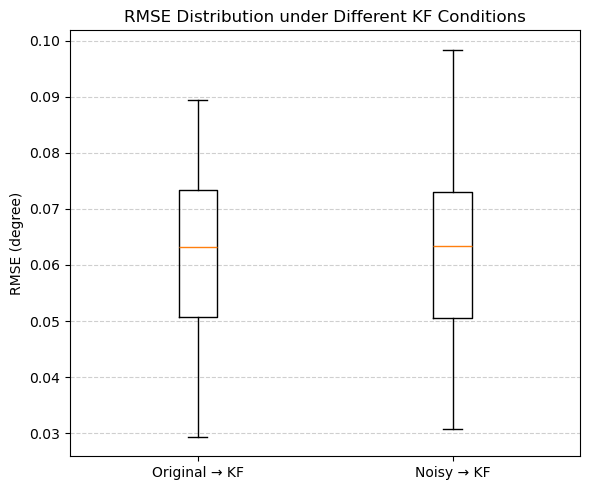

In [59]:
plt.figure(figsize=(6, 5))

plt.boxplot(
    [rmse_df["KF_clean"], rmse_df["KF_noisy"]],
    tick_labels=["Original → KF", "Noisy → KF"],
    showfliers=True
)

plt.ylabel("RMSE (degree)")
plt.title("RMSE Distribution under Different KF Conditions")

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [60]:
noise_levels = np.linspace(0, 0.005, 12)
drift_mags   = np.linspace(0, 0.005, 12)
spike_probs  = np.linspace(0, 0.3, 12)

In [ ]:
# 1. 首先，计算基准KF结果（使用原始数据）
print("计算基准KF结果（无噪声）...")
baseline_kf_results = []

for track_id, group in baseline_df.groupby("track_id"):
    lng_kf, lat_kf = run_kf_on_trajectory(
        group,
        obs_lng_col="lng_original",
        obs_lat_col="lat_original"
    )
    
    group = group.copy()
    group["lng_kf_clean"] = lng_kf
    group["lat_kf_clean"] = lat_kf
    baseline_kf_results.append(group)

baseline_kf_df = pd.concat(baseline_kf_results, ignore_index=True)

# 2. 定义噪声参数范围
noise_levels = np.linspace(0, 0.005, 12)
drift_mags = np.linspace(0, 0.005, 12)
spike_probs = np.linspace(0, 0.3, 12)

# 3. 实验主循环
rmse_records = []

# 高斯噪声实验
print("进行高斯噪声实验...")
for nl in noise_levels:
    print(f"  噪声水平: {nl:.6f}")
    
    # 添加高斯噪声
    noisy_df = add_noise_to_all_baselines_df(
        baseline_df,
        noise_type='gaussian',
        noise_level=nl
    )
    
    # 对噪声数据运行KF
    kf_results_noisy = []
    for track_id, group in noisy_df.groupby("track_id"):
        lng_kf, lat_kf = run_kf_on_trajectory(
            group,
            obs_lng_col="lng_noisy",
            obs_lat_col="lat_noisy"
        )
        
        group = group.copy()
        group["lng_kf_noisy"] = lng_kf
        group["lat_kf_noisy"] = lat_kf
        kf_results_noisy.append(group)
    
    kf_noisy_df = pd.concat(kf_results_noisy, ignore_index=True)
    
    # 合并基准KF结果
    comparison_df = pd.merge(
        kf_noisy_df,
        baseline_kf_df[['track_id', 'point_idx', 'lng_kf_clean', 'lat_kf_clean']],
        on=['track_id', 'point_idx'],
        how='left'
    )
    
    # 计算每个轨迹的RMSE
    for track_id, group in comparison_df.groupby("track_id"):
        rmse_clean = trajectory_rmse(
            group,
            pred_lng="lng_kf_clean",
            pred_lat="lat_kf_clean",
            gt_lng="lng_original",
            gt_lat="lat_original"
        )
        
        rmse_noisy = trajectory_rmse(
            group,
            pred_lng="lng_kf_noisy",
            pred_lat="lat_kf_noisy",
            gt_lng="lng_original",
            gt_lat="lat_original"
        )
        
        rmse_records.append({
            "noise_type": "gaussian",
            "param_name": "noise_level",
            "param_value": nl,
            "track_id": track_id,
            "KF_clean": rmse_clean,
            "KF_noisy": rmse_noisy,
            "RMSE_change": rmse_noisy - rmse_clean,
            "RMSE_ratio": rmse_noisy / rmse_clean if rmse_clean > 0 else np.nan
        })

# 漂移噪声实验
print("进行漂移噪声实验...")
for dm in drift_mags:
    print(f"  漂移幅度: {dm:.6f}")
    
    noisy_df = add_noise_to_all_baselines_df(
        baseline_df,
        noise_type='drift',
        drift_magnitude=dm
    )
    
    kf_results_noisy = []
    for track_id, group in noisy_df.groupby("track_id"):
        lng_kf, lat_kf = run_kf_on_trajectory(
            group,
            obs_lng_col="lng_noisy",
            obs_lat_col="lat_noisy"
        )
        
        group = group.copy()
        group["lng_kf_noisy"] = lng_kf
        group["lat_kf_noisy"] = lat_kf
        kf_results_noisy.append(group)
    
    kf_noisy_df = pd.concat(kf_results_noisy, ignore_index=True)
    
    comparison_df = pd.merge(
        kf_noisy_df,
        baseline_kf_df[['track_id', 'point_idx', 'lng_kf_clean', 'lat_kf_clean']],
        on=['track_id', 'point_idx'],
        how='left'
    )
    
    for track_id, group in comparison_df.groupby("track_id"):
        rmse_clean = trajectory_rmse(
            group,
            pred_lng="lng_kf_clean",
            pred_lat="lat_kf_clean",
            gt_lng="lng_original",
            gt_lat="lat_original"
        )
        
        rmse_noisy = trajectory_rmse(
            group,
            pred_lng="lng_kf_noisy",
            pred_lat="lat_kf_noisy",
            gt_lng="lng_original",
            gt_lat="lat_original"
        )
        
        rmse_records.append({
            "noise_type": "drift",
            "param_name": "drift_magnitude",
            "param_value": dm,
            "track_id": track_id,
            "KF_clean": rmse_clean,
            "KF_noisy": rmse_noisy,
            "RMSE_change": rmse_noisy - rmse_clean,
            "RMSE_ratio": rmse_noisy / rmse_clean if rmse_clean > 0 else np.nan
        })

# 脉冲噪声实验
print("进行脉冲噪声实验...")
for sp in spike_probs:
    print(f"  脉冲概率: {sp:.3f}")
    
    noisy_df = add_noise_to_all_baselines_df(
        baseline_df,
        noise_type='spike',
        spike_probability=sp
    )
    
    kf_results_noisy = []
    for track_id, group in noisy_df.groupby("track_id"):
        lng_kf, lat_kf = run_kf_on_trajectory(
            group,
            obs_lng_col="lng_noisy",
            obs_lat_col="lat_noisy"
        )
        
        group = group.copy()
        group["lng_kf_noisy"] = lng_kf
        group["lat_kf_noisy"] = lat_kf
        kf_results_noisy.append(group)
    
    kf_noisy_df = pd.concat(kf_results_noisy, ignore_index=True)
    
    comparison_df = pd.merge(
        kf_noisy_df,
        baseline_kf_df[['track_id', 'point_idx', 'lng_kf_clean', 'lat_kf_clean']],
        on=['track_id', 'point_idx'],
        how='left'
    )
    
    for track_id, group in comparison_df.groupby("track_id"):
        rmse_clean = trajectory_rmse(
            group,
            pred_lng="lng_kf_clean",
            pred_lat="lat_kf_clean",
            gt_lng="lng_original",
            gt_lat="lat_original"
        )
        
        rmse_noisy = trajectory_rmse(
            group,
            pred_lng="lng_kf_noisy",
            pred_lat="lat_kf_noisy",
            gt_lng="lng_original",
            gt_lat="lat_original"
        )
        
        rmse_records.append({
            "noise_type": "spike",
            "param_name": "spike_probability",
            "param_value": sp,
            "track_id": track_id,
            "KF_clean": rmse_clean,
            "KF_noisy": rmse_noisy,
            "RMSE_change": rmse_noisy - rmse_clean,
            "RMSE_ratio": rmse_noisy / rmse_clean if rmse_clean > 0 else np.nan
        })

# 4. 创建结果DataFrame并分析
rmse_df = pd.DataFrame(rmse_records)

print("\n实验完成！结果摘要：")
print(f"总实验配置数: {len(rmse_df)}")
print(f"噪声类型分布: {rmse_df['noise_type'].value_counts().to_dict()}")

# 计算每种噪声类型的平均RMSE变化
summary = rmse_df.groupby(['noise_type', 'param_value']).agg({
    'KF_clean': 'mean',
    'KF_noisy': 'mean',
    'RMSE_change': 'mean',
    'RMSE_ratio': 'mean'
}).reset_index()

print("\n按噪声类型和参数值的平均RMSE:")
print(summary)

# 5. 可选：保存结果
rmse_df.to_csv('kf_noise_experiment_results.csv', index=False)
summary.to_csv('kf_noise_experiment_summary.csv', index=False)

print("\n结果已保存到CSV文件。")

计算基准KF结果（无噪声）...
进行高斯噪声实验...
  噪声水平: 0.000000
  噪声水平: 0.000455
  噪声水平: 0.000909
  噪声水平: 0.001364
  噪声水平: 0.001818
  噪声水平: 0.002273
  噪声水平: 0.002727
  噪声水平: 0.003182
  噪声水平: 0.003636
  噪声水平: 0.004091
  噪声水平: 0.004545
  噪声水平: 0.005000
进行漂移噪声实验...
  漂移幅度: 0.000000
  漂移幅度: 0.000455
  漂移幅度: 0.000909
  漂移幅度: 0.001364
  漂移幅度: 0.001818
  漂移幅度: 0.002273
  漂移幅度: 0.002727
  漂移幅度: 0.003182
  漂移幅度: 0.003636
  漂移幅度: 0.004091
  漂移幅度: 0.004545
  漂移幅度: 0.005000
进行脉冲噪声实验...
  脉冲概率: 0.000
  脉冲概率: 0.027
  脉冲概率: 0.055
  脉冲概率: 0.082
  脉冲概率: 0.109
  脉冲概率: 0.136
  脉冲概率: 0.164
  脉冲概率: 0.191
  脉冲概率: 0.218
  脉冲概率: 0.245
  脉冲概率: 0.273
  脉冲概率: 0.300

实验完成！结果摘要：
总实验配置数: 3600
噪声类型分布: {'gaussian': 1200, 'drift': 1200, 'spike': 1200}

按噪声类型和参数值的平均RMSE:
   noise_type  param_value  KF_clean  KF_noisy   RMSE_change  RMSE_ratio
0       drift     0.000000  0.062337  0.062337  4.699283e-11    1.000000
1       drift     0.000455  0.062337  0.062289 -4.737155e-05    0.999113
2       drift     0.000909  0.062337  0.062246 -9.0

In [63]:
print(summary.head())

  noise_type  param_value  KF_clean  KF_noisy   RMSE_change  RMSE_ratio
0      drift     0.000000  0.062337  0.062337  4.699283e-11    1.000000
1      drift     0.000455  0.062337  0.062289 -4.737155e-05    0.999113
2      drift     0.000909  0.062337  0.062246 -9.067157e-05    0.998292
3      drift     0.001364  0.062337  0.062207 -1.299304e-04    0.997536
4      drift     0.001818  0.062337  0.062171 -1.651432e-04    0.996846


C:\Users\93176\AppData\Local\Temp\ipykernel_6544\2023506996.py:131: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\93176\AppData\Local\Temp\ipykernel_6544\2023506996.py:131: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\93176\AppData\Local\Temp\ipykernel_6544\2023506996.py:131: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) Arial.
  plt.tight_layout()
e:\Users\93176\anaconda3\envs\traffic\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Users\93176\anaconda3\envs\traffic\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
e:\Users\93176\anaconda3\envs\traffic\Lib\s

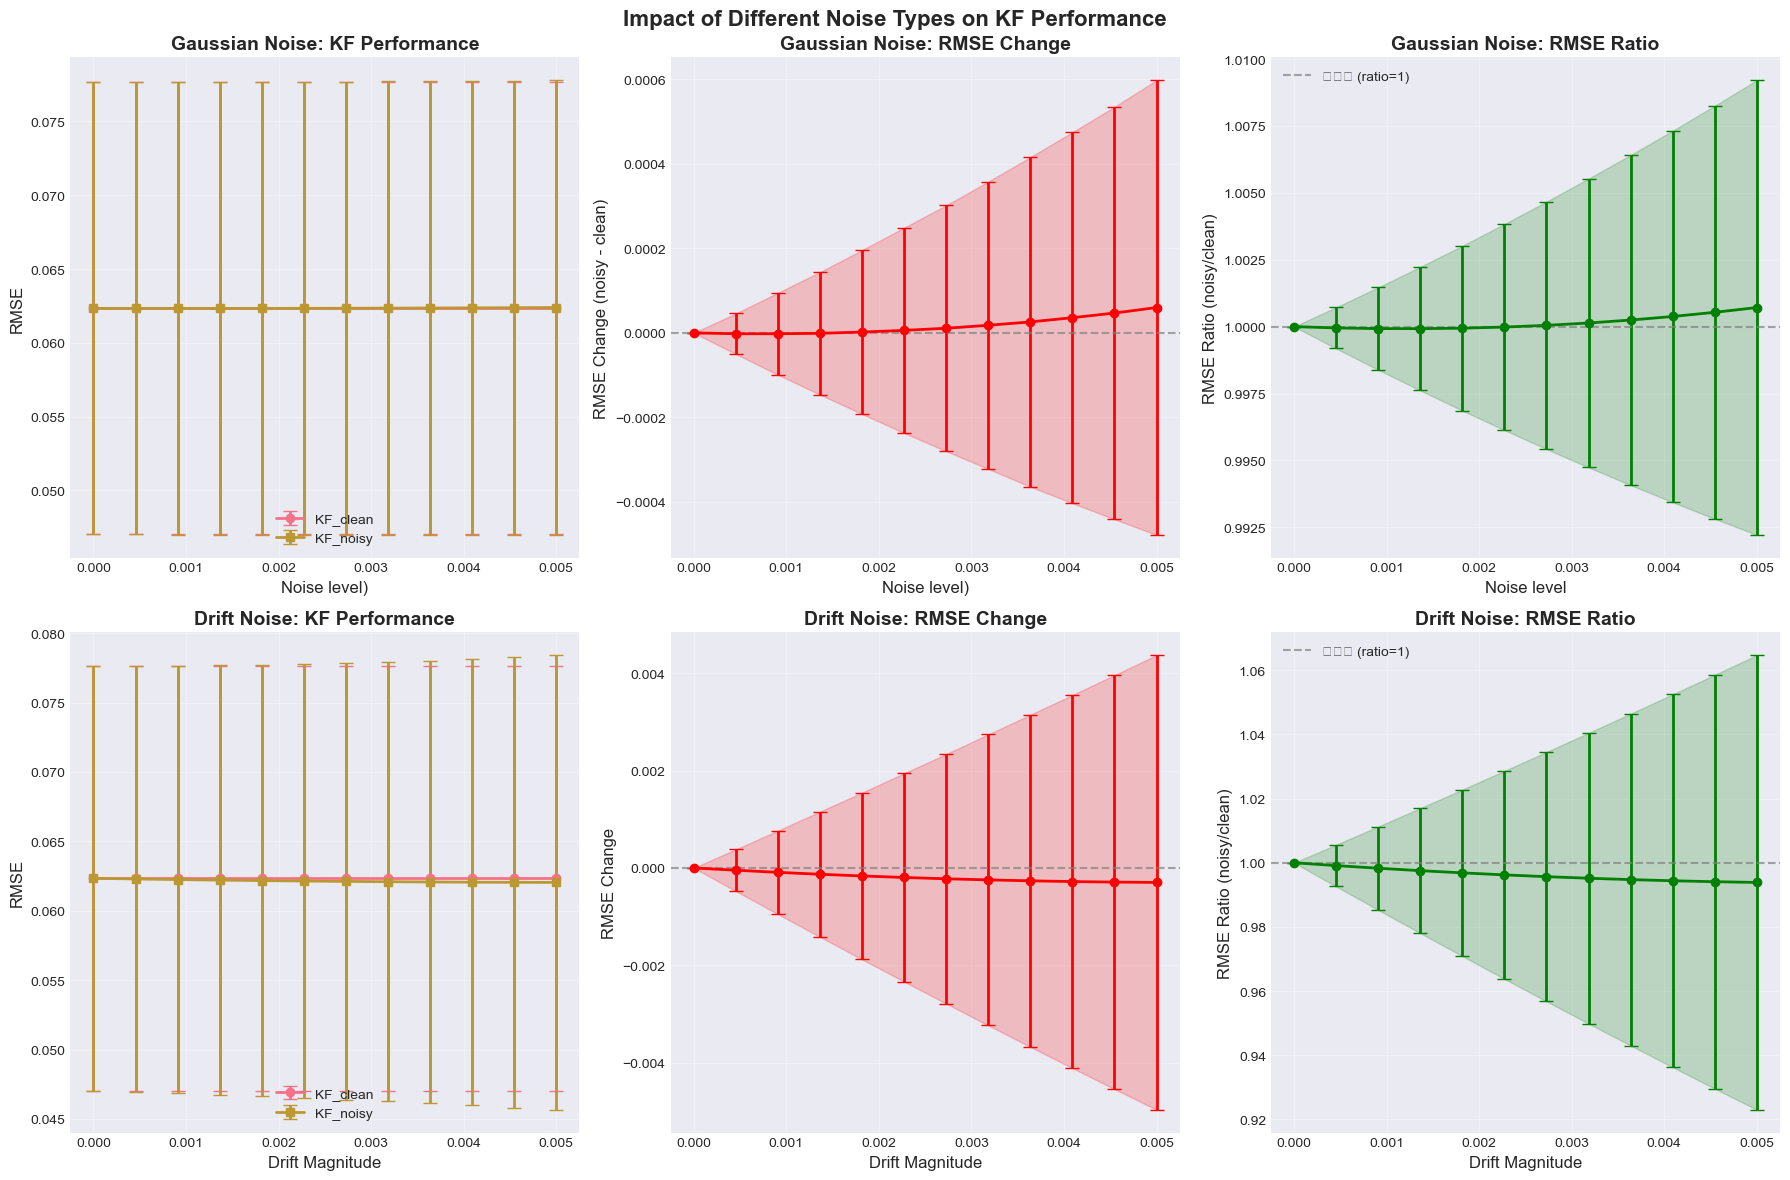

C:\Users\93176\AppData\Local\Temp\ipykernel_6544\2023506996.py:185: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\93176\AppData\Local\Temp\ipykernel_6544\2023506996.py:185: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\93176\AppData\Local\Temp\ipykernel_6544\2023506996.py:185: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) Arial.
  plt.tight_layout()


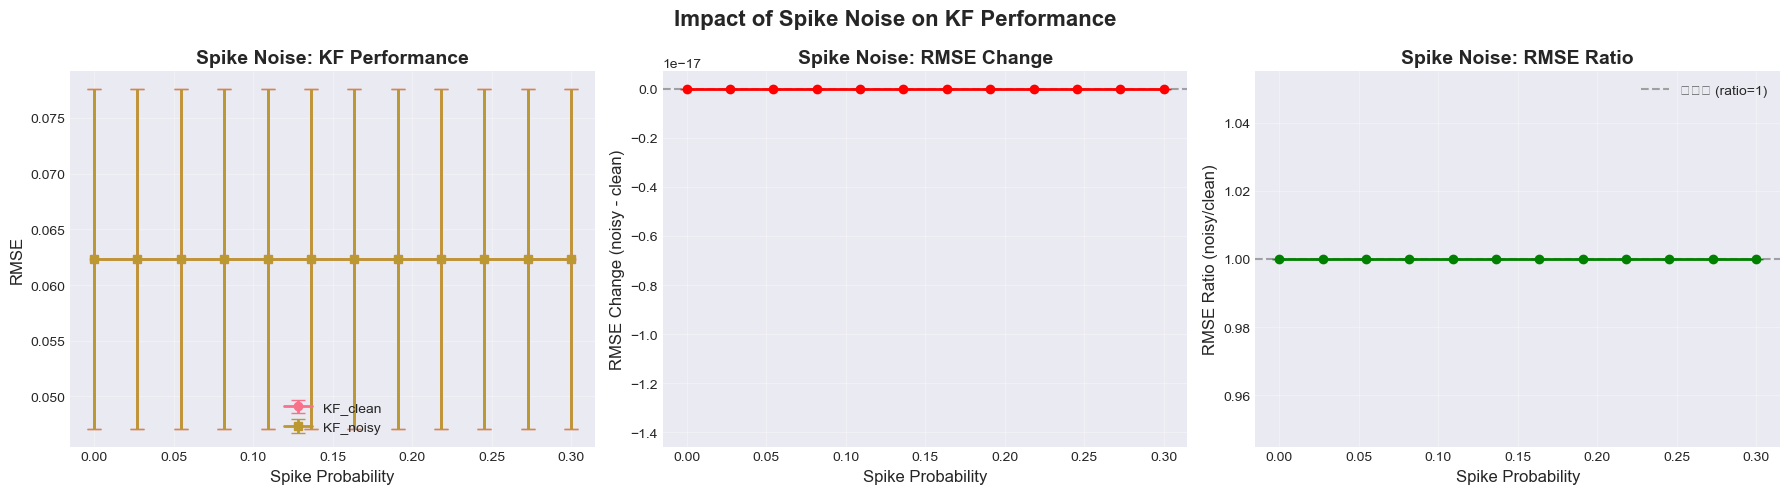

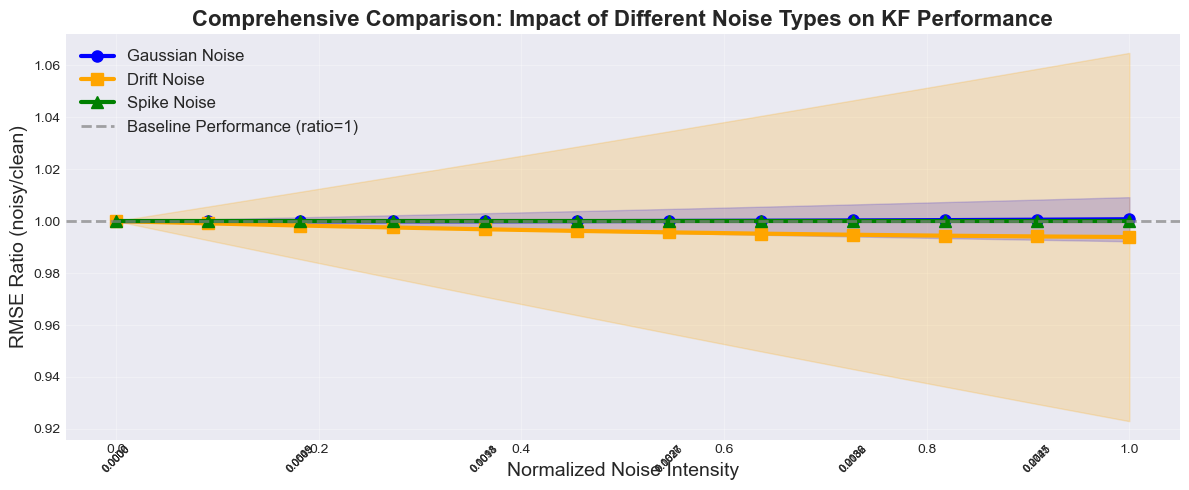

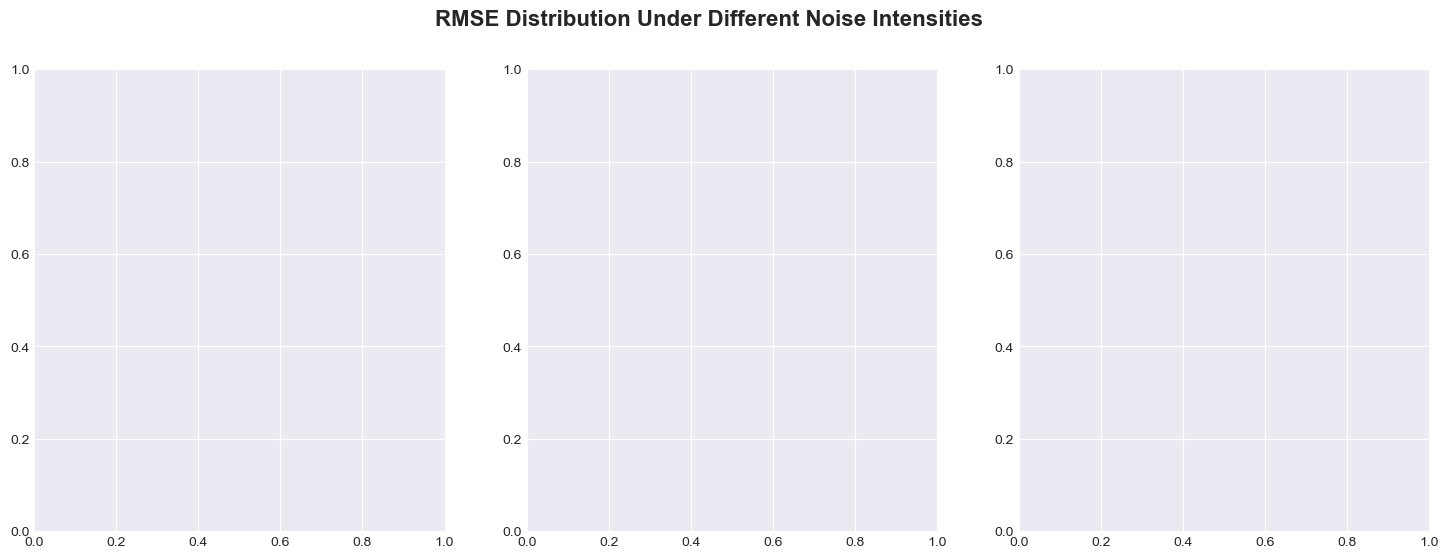

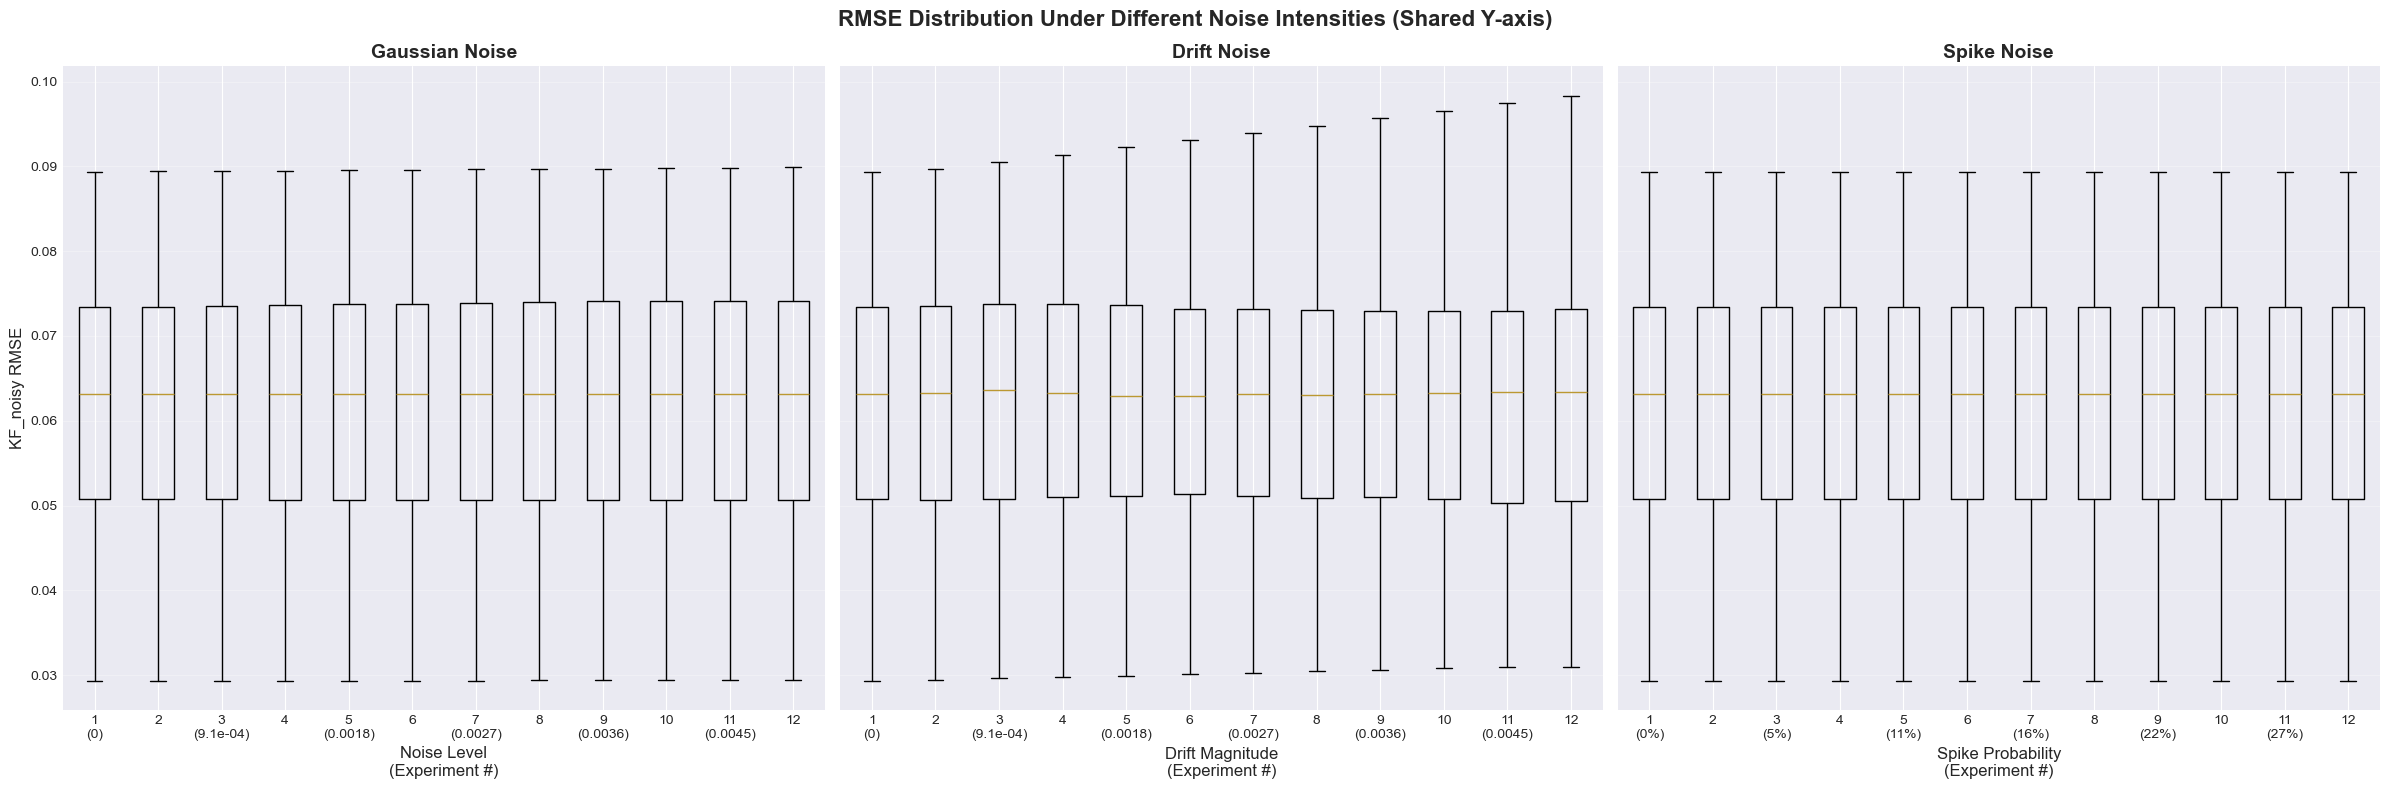

可视化完成！


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 创建图表
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Impact of Different Noise Types on KF Performance', fontsize=16, fontweight='bold')

# 如果已经有rmse_df，可以直接使用
# 否则需要先运行之前的实验代码生成rmse_df

# 1. 按噪声类型分组计算统计量
summary_stats = rmse_df.groupby(['noise_type', 'param_value']).agg({
    'KF_clean': ['mean', 'std'],
    'KF_noisy': ['mean', 'std'],
    'RMSE_change': ['mean', 'std'],
    'RMSE_ratio': ['mean', 'std']
}).round(6)

# 重置索引以便绘图
summary_stats.reset_index(inplace=True)

# 为了方便访问，重命名列
summary_stats.columns = ['noise_type', 'param_value', 
                        'KF_clean_mean', 'KF_clean_std',
                        'KF_noisy_mean', 'KF_noisy_std',
                        'RMSE_change_mean', 'RMSE_change_std',
                        'RMSE_ratio_mean', 'RMSE_ratio_std']

# 2. 绘制高斯噪声的影响 (第一行)
gaussian_data = summary_stats[summary_stats['noise_type'] == 'gaussian']

# 子图1: KF_clean vs KF_noisy
ax1 = axes[0, 0]
ax1.errorbar(gaussian_data['param_value'], gaussian_data['KF_clean_mean'], 
            yerr=gaussian_data['KF_clean_std'], label='KF_clean', 
            fmt='o-', capsize=5, linewidth=2)
ax1.errorbar(gaussian_data['param_value'], gaussian_data['KF_noisy_mean'], 
            yerr=gaussian_data['KF_noisy_std'], label='KF_noisy',
            fmt='s-', capsize=5, linewidth=2)
ax1.set_xlabel('Noise level)', fontsize=12)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_title('Gaussian Noise: KF Performance', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 子图2: RMSE变化量
ax2 = axes[0, 1]
ax2.errorbar(gaussian_data['param_value'], gaussian_data['RMSE_change_mean'], 
            yerr=gaussian_data['RMSE_change_std'], 
            fmt='o-', color='red', capsize=5, linewidth=2)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax2.fill_between(gaussian_data['param_value'], 
                gaussian_data['RMSE_change_mean'] - gaussian_data['RMSE_change_std'],
                gaussian_data['RMSE_change_mean'] + gaussian_data['RMSE_change_std'],
                alpha=0.2, color='red')
ax2.set_xlabel('Noise level)', fontsize=12)
ax2.set_ylabel('RMSE Change (noisy - clean)', fontsize=12)
ax2.set_title('Gaussian Noise: RMSE Change', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 子图3: RMSE比率
ax3 = axes[0, 2]
ax3.errorbar(gaussian_data['param_value'], gaussian_data['RMSE_ratio_mean'], 
            yerr=gaussian_data['RMSE_ratio_std'], 
            fmt='o-', color='green', capsize=5, linewidth=2)
ax3.axhline(y=1, color='gray', linestyle='--', alpha=0.7, label='基准线 (ratio=1)')
ax3.fill_between(gaussian_data['param_value'], 
                gaussian_data['RMSE_ratio_mean'] - gaussian_data['RMSE_ratio_std'],
                gaussian_data['RMSE_ratio_mean'] + gaussian_data['RMSE_ratio_std'],
                alpha=0.2, color='green')
ax3.set_xlabel('Noise level', fontsize=12)
ax3.set_ylabel('RMSE Ratio (noisy/clean)', fontsize=12)
ax3.set_title('Gaussian Noise: RMSE Ratio', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 3. 绘制漂移噪声的影响 (第二行)
drift_data = summary_stats[summary_stats['noise_type'] == 'drift']

# 子图4: KF_clean vs KF_noisy
ax4 = axes[1, 0]
ax4.errorbar(drift_data['param_value'], drift_data['KF_clean_mean'], 
            yerr=drift_data['KF_clean_std'], label='KF_clean', 
            fmt='o-', capsize=5, linewidth=2)
ax4.errorbar(drift_data['param_value'], drift_data['KF_noisy_mean'], 
            yerr=drift_data['KF_noisy_std'], label='KF_noisy',
            fmt='s-', capsize=5, linewidth=2)
ax4.set_xlabel('Drift Magnitude', fontsize=12)
ax4.set_ylabel('RMSE', fontsize=12)
ax4.set_title('Drift Noise: KF Performance', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 子图5: RMSE变化量
ax5 = axes[1, 1]
ax5.errorbar(drift_data['param_value'], drift_data['RMSE_change_mean'], 
            yerr=drift_data['RMSE_change_std'], 
            fmt='o-', color='red', capsize=5, linewidth=2)
ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax5.fill_between(drift_data['param_value'], 
                drift_data['RMSE_change_mean'] - drift_data['RMSE_change_std'],
                drift_data['RMSE_change_mean'] + drift_data['RMSE_change_std'],
                alpha=0.2, color='red')
ax5.set_xlabel('Drift Magnitude', fontsize=12)
ax5.set_ylabel('RMSE Change', fontsize=12)
ax5.set_title('Drift Noise: RMSE Change', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)

# 子图6: RMSE比率
ax6 = axes[1, 2]
ax6.errorbar(drift_data['param_value'], drift_data['RMSE_ratio_mean'], 
            yerr=drift_data['RMSE_ratio_std'], 
            fmt='o-', color='green', capsize=5, linewidth=2)
ax6.axhline(y=1, color='gray', linestyle='--', alpha=0.7, label='基准线 (ratio=1)')
ax6.fill_between(drift_data['param_value'], 
                drift_data['RMSE_ratio_mean'] - drift_data['RMSE_ratio_std'],
                drift_data['RMSE_ratio_mean'] + drift_data['RMSE_ratio_std'],
                alpha=0.2, color='green')
ax6.set_xlabel('Drift Magnitude', fontsize=12)
ax6.set_ylabel('RMSE Ratio (noisy/clean)', fontsize=12)
ax6.set_title('Drift Noise: RMSE Ratio', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. 单独绘制脉冲噪声的影响（需要第三行）
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
fig2.suptitle('Impact of Spike Noise on KF Performance', fontsize=16, fontweight='bold')

spike_data = summary_stats[summary_stats['noise_type'] == 'spike']

# 子图1: KF_clean vs KF_noisy
ax1 = axes2[0]
ax1.errorbar(spike_data['param_value'], spike_data['KF_clean_mean'], 
            yerr=spike_data['KF_clean_std'], label='KF_clean', 
            fmt='o-', capsize=5, linewidth=2)
ax1.errorbar(spike_data['param_value'], spike_data['KF_noisy_mean'], 
            yerr=spike_data['KF_noisy_std'], label='KF_noisy',
            fmt='s-', capsize=5, linewidth=2)
ax1.set_xlabel('Spike Probability', fontsize=12)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_title('Spike Noise: KF Performance', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 子图2: RMSE变化量
ax2 = axes2[1]
ax2.errorbar(spike_data['param_value'], spike_data['RMSE_change_mean'], 
            yerr=spike_data['RMSE_change_std'], 
            fmt='o-', color='red', capsize=5, linewidth=2)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax2.fill_between(spike_data['param_value'], 
                spike_data['RMSE_change_mean'] - spike_data['RMSE_change_std'],
                spike_data['RMSE_change_mean'] + spike_data['RMSE_change_std'],
                alpha=0.2, color='red')
ax2.set_xlabel('Spike Probability', fontsize=12)
ax2.set_ylabel('RMSE Change (noisy - clean)', fontsize=12)
ax2.set_title('Spike Noise: RMSE Change', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 子图3: RMSE比率
ax3 = axes2[2]
ax3.errorbar(spike_data['param_value'], spike_data['RMSE_ratio_mean'], 
            yerr=spike_data['RMSE_ratio_std'], 
            fmt='o-', color='green', capsize=5, linewidth=2)
ax3.axhline(y=1, color='gray', linestyle='--', alpha=0.7, label='基准线 (ratio=1)')
ax3.fill_between(spike_data['param_value'], 
                spike_data['RMSE_ratio_mean'] - spike_data['RMSE_ratio_std'],
                spike_data['RMSE_ratio_mean'] + spike_data['RMSE_ratio_std'],
                alpha=0.2, color='green')
ax3.set_xlabel('Spike Probability', fontsize=12)
ax3.set_ylabel('RMSE Ratio (noisy/clean)', fontsize=12)
ax3.set_title('Spike Noise: RMSE Ratio', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. 综合对比图：三种噪声类型的性能下降对比
fig3, ax = plt.subplots(figsize=(12, 5))

# Prepare data
gaussian_data = summary_stats[summary_stats['noise_type'] == 'gaussian']
drift_data = summary_stats[summary_stats['noise_type'] == 'drift']
spike_data = summary_stats[summary_stats['noise_type'] == 'spike']

# Normalize parameter values for comparison on the same scale
def normalize_param(values):
    return (values - values.min()) / (values.max() - values.min())

# Plot three curves
ax.plot(normalize_param(gaussian_data['param_value']), 
        gaussian_data['RMSE_ratio_mean'], 'o-', linewidth=3, markersize=8, 
        label='Gaussian Noise', color='blue')
ax.fill_between(normalize_param(gaussian_data['param_value']),
                gaussian_data['RMSE_ratio_mean'] - gaussian_data['RMSE_ratio_std'],
                gaussian_data['RMSE_ratio_mean'] + gaussian_data['RMSE_ratio_std'],
                alpha=0.2, color='blue')

ax.plot(normalize_param(drift_data['param_value']), 
        drift_data['RMSE_ratio_mean'], 's-', linewidth=3, markersize=8,
        label='Drift Noise', color='orange')
ax.fill_between(normalize_param(drift_data['param_value']),
                drift_data['RMSE_ratio_mean'] - drift_data['RMSE_ratio_std'],
                drift_data['RMSE_ratio_mean'] + drift_data['RMSE_ratio_std'],
                alpha=0.2, color='orange')

ax.plot(normalize_param(spike_data['param_value']), 
        spike_data['RMSE_ratio_mean'], '^-', linewidth=3, markersize=8,
        label='Spike Noise', color='green')
ax.fill_between(normalize_param(spike_data['param_value']),
                spike_data['RMSE_ratio_mean'] - spike_data['RMSE_ratio_std'],
                spike_data['RMSE_ratio_mean'] + spike_data['RMSE_ratio_std'],
                alpha=0.2, color='green')

# Add baseline
ax.axhline(y=1, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Baseline Performance (ratio=1)')

ax.set_xlabel('Normalized Noise Intensity', fontsize=14)
ax.set_ylabel('RMSE Ratio (noisy/clean)', fontsize=14)
ax.set_title('Comprehensive Comparison: Impact of Different Noise Types on KF Performance', 
            fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Add additional x-axis labels showing original values
def add_original_scale_labels(ax, data, label_prefix):
    normalized = normalize_param(data['param_value'])
    for i, (norm_val, orig_val) in enumerate(zip(normalized, data['param_value'])):
        if i % 2 == 0:  # Show labels every other point
            ax.text(norm_val, -0.08, f'{orig_val:.4f}', ha='center', 
                   transform=ax.get_xaxis_transform(), fontsize=8, rotation=45)

add_original_scale_labels(ax, gaussian_data, "Gauss")
add_original_scale_labels(ax, drift_data, "Drift")
add_original_scale_labels(ax, spike_data, "Spike")

plt.tight_layout()
plt.show()

# 6. Box plot: RMSE distribution under different noise types
fig4, axes4 = plt.subplots(1, 3, figsize=(18, 6))
fig4.suptitle('RMSE Distribution Under Different Noise Intensities', fontsize=16, fontweight='bold')

# Select representative noise levels for visualization
sample_params = {
    'gaussian': [0.000, 0.002, 0.004],
    'drift': [0.000, 0.002, 0.004],
    'spike': [0.0, 0.1, 0.2]
}

fig5, axes5 = plt.subplots(1, 3, figsize=(24, 8), sharey=True)
fig5.suptitle('RMSE Distribution Under Different Noise Intensities (Shared Y-axis)', 
              fontsize=16, fontweight='bold')

noise_type_names = {
    'gaussian': 'Gaussian',
    'drift': 'Drift',
    'spike': 'Spike'
}

param_names = {
    'gaussian': 'Noise Level',
    'drift': 'Drift Magnitude',
    'spike': 'Spike Probability'
}

for idx, noise_type in enumerate(['gaussian', 'drift', 'spike']):
    ax = axes5[idx]
    
    # Filter data
    subset = rmse_df[rmse_df['noise_type'] == noise_type]
    
    # 获取所有唯一的参数值并按升序排序
    unique_params = np.sort(subset['param_value'].unique())
    
    # 确保我们有12个参数值
    if len(unique_params) >= 12:
        selected_params = unique_params[:12]
    else:
        selected_params = unique_params
    
    # Create data lists for each parameter value
    data_to_plot = []
    param_labels = []
    
    for i, param in enumerate(selected_params):
        param_data = subset[subset['param_value'] == param]['KF_noisy']
        data_to_plot.append(param_data)
        
        # 简化标签：只显示索引或简化格式
        if noise_type == 'spike':
            param_labels.append(f'{i+1}\n({param:.0%})' if i % 2 == 0 else f'{i+1}')
        else:
            if param == 0:
                param_labels.append(f'{i+1}\n(0)')
            elif i % 2 == 0:  # 每隔一个显示完整值
                param_labels.append(f'{i+1}\n({param:.1e})' if param < 0.001 else f'{i+1}\n({param:.4f})')
            else:
                param_labels.append(f'{i+1}')
    
    # Plot box plot
    box = ax.boxplot(data_to_plot, tick_labels=param_labels)
    
    # 设置标签和标题
    ax.set_xlabel(f'{param_names[noise_type]}\n(Experiment #)', fontsize=12)
    if idx == 0:  # 只在第一个子图显示y轴标签
        ax.set_ylabel('KF_noisy RMSE', fontsize=12)
    
    ax.set_title(f'{noise_type_names[noise_type]} Noise', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # 旋转x轴标签
    ax.set_xticklabels(param_labels, rotation=0, ha='center')
plt.tight_layout()
plt.show()

print("可视化完成！")